In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
#import matplotlib.dates as mdates


# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

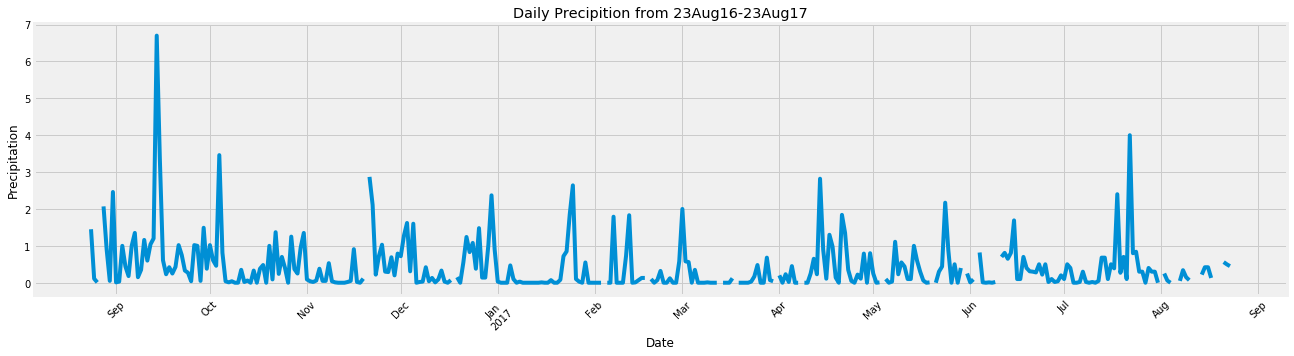

In [8]:
#pd.options.display.max_rows =3000
# Design a query to retrieve the last 12 months of precipitation data and plot the results

max_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
max_date= datetime.datetime.strptime(max_date, '%Y-%m-%d')

# Calculate the date 1 year ago from today
max_minus_1year= max_date- datetime.timedelta(days=365)
max_minus_1year

# Perform a query to retrieve the data and precipitation scores

# sql = "select * from measurement \
#        WHERE date > '2016-08-22' \
#        ORDER BY date"
# df =pd.read_sql(sql, engine)
# def func1():
query1=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >max_minus_1year).group_by(Measurement.date).order_by(Measurement.date)

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df=pd.read_sql(query1.statement, query1.session.bind,index_col='date').sort_index()
df.index=pd.to_datetime(df.index)
# Use Pandas Plotting with Matplotlib to plot the data

y= df['prcp']

type(df.index[0])
df.plot(use_index=True, rot=45,legend=False, figsize=(20,5))

plt.title('Daily Precipition from 23Aug16-23Aug17')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.xticks()#(range(len(df['date']),df['date']))
plt.show()

data=df

In [9]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data.describe().round(2)

,prcp
count,344.00
mean,0.43
std,0.71
min,0.00
25%,0.01
50%,0.14
75%,0.57
max,6.70


In [10]:
# How many stations are available in this dataset?

# sql = "select * from station"
# df =pd.read_sql(sql, engine)
# df

query2=session.query(func.count(Station.station))
station_count=query2.all()[0][0]
print(f'There are a total of {station_count} weather stations in this dataset.')

There are a total of 9 weather stations in this dataset.


In [11]:
# What are the most active stations?
# List the stations and the counts in descending order.

# sql = "select * from measurement"
# df =pd.read_sql(sql, engine)
# df

# def measurement_count():
query3=session.query(Measurement.station,func.count(Measurement.station).label('total observations'))\
                                             .group_by(Measurement.station)\
                                             .order_by(func.count(Measurement.station).desc())

df=pd.read_sql(query3.statement, query3.session.bind)
df

,station,total observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [12]:
def table_info():
    q1= session.query(Measurement)
    df=pd.read_sql(q1.statement, q1.session.bind)
    q2= session.query(Station)
    df2=pd.read_sql(q2.statement, q2.session.bind)
    print(df.head(1))
    print()
    print(df2.head(1))
table_info()

   id      station        date  prcp  tobs
0   1  USC00519397  2010-01-01  0.08  65.0

   id      station                  name  latitude  longitude  elevation
0   1  USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0


In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station= df['station'][0]

query4=session.query(func.min(Measurement.tobs).label('Min'),
                     func.max(Measurement.tobs).label('Max'),
                     func.avg(Measurement.tobs).label('Avg'),
                     func.count(Measurement.tobs).label('Count')).filter(Measurement.station==most_active_station)

df2=pd.read_sql(query4.statement, query4.session.bind)
df2



,Min,Max,Avg,Count
0,54.0,85.0,71.663781,2772


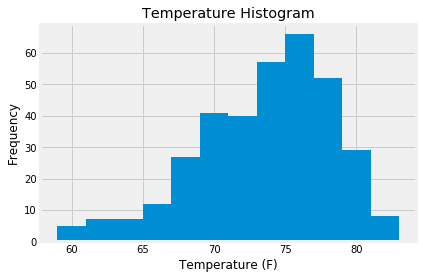

In [14]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query5=session.query(Measurement.date, Measurement.tobs).filter(Measurement.station==most_active_station, Measurement.date >max_minus_1year)
df3= pd.read_sql(query5.statement, query5.session.bind)
df3.head()

df3.hist(column=['tobs'],bins=12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Temperature Histogram")
plt.show()

[(71.0, 79.01785714285714, 84.0)]


Text(0.5,1,'Trip Avg Temp')

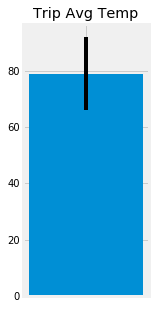

In [15]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
        
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), 
                         func.avg(Measurement.tobs), 
                         func.max(Measurement.tobs)).\
                         filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
x=list(calc_temps('2017-08-01', '2017-08-14'))
print(x)
ind=1

plt.figure(figsize=(2,5))
plt.bar(1,x[0][1],yerr=x[0][2]-x[0][0], tick_label = "")
plt.title('Trip Avg Temp')






In [16]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [17]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [18]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [19]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")


[(62.0, 69.15384615384616, 77.0)]

In [20]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [21]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [22]:
# Plot the daily normals as an area plot with `stacked=False`
